In [1]:
import sys
import json
import time
import pathlib
from copy import deepcopy
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from agent_model import AgentModel
from agent_model.util import parse_data, plot_agent

data_files_path = pathlib.Path('data_files')
b2_data_path = pathlib.Path('simoc_server/test/b2_data_files')

In [3]:
with open(data_files_path / 'agent_desc.json') as f:
    agent_desc = json.load(f)
with open(data_files_path / 'agent_conn.json') as f:
    agent_conn = json.load(f)
with open(data_files_path / 'currency_desc.json') as f:
    currency_desc = json.load(f)

### Generate B2 Sun Data
Outputs of the cell below, `hourly_par` and `monthly_par`, are hardcoded into `custom_function.b2_sun`.

Saving to hourly_par.csv (n=24), monthly_par.csv (n=60)


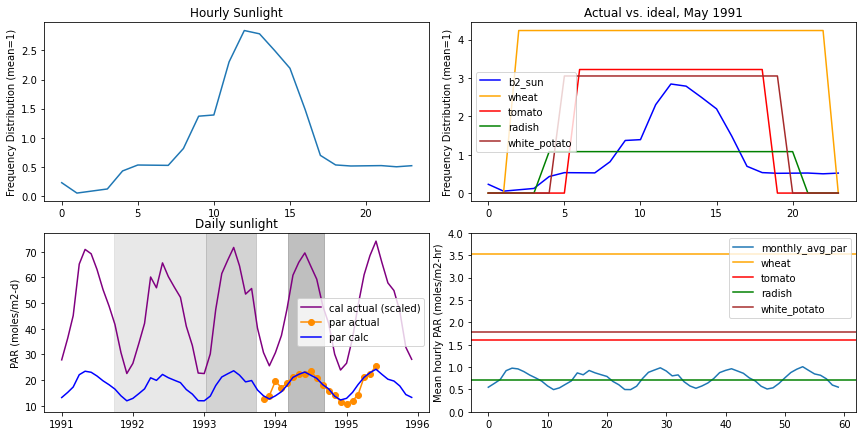

In [4]:
# Sun Agent

# Hourly PAR (moles/m2-s) for December 24, 1993 to December 28, 1993 are provided
# in Marino Figure 2b from inside IAB. Read in with inferred timestamps.
daily_light = pd.read_csv(b2_data_path / 'marino_figure2b_data.csv', header=None)
daily_light['timestamp'] = pd.to_datetime('December 24, 1993 00:00:00')
daily_light['timedelta'] = daily_light[0].apply(lambda d: timedelta(days=d))
daily_light['timestamp'] += daily_light['timedelta']
# Calculate mean values by hour across 4 sample days.
hourly_par = [None] * 24
for i in range(24):
    in_range = daily_light['timestamp'].dt.hour == i
    if sum(in_range) > 0:
        hourly_par[i] = daily_light.loc[in_range, 1].mean()
# Interpolate hours with no timestamps
for i in range(len(hourly_par)):
    if hourly_par[i] == None:
        hourly_par[i] = (hourly_par[i-1] + hourly_par[i+1])/2
# Scale to mean = 1
hourly_par /= (sum(hourly_par) / len(hourly_par))

# Monthly sunlight (cal/cm2) for January 1991 to December 1995 is provided 
# in Marino Figure 4 from LANGLEY. Read in and timestamp e.g. '01-01-1991 00:00:00'
raw_4 = pd.read_csv('simoc_server/test/b2_data_files/marino_figure4_data.csv', header=None)
months = pd.date_range(start='12/31/1990', periods=60, freq='M')
months += timedelta(days=1)
df = pd.DataFrame()
df['cal_per_m2'] = raw_4[1]
df.set_index(months, inplace=True)

# Weekly PAR inside B2 (moles/m2-d) for November 1993 to May 1995 are provided
# in Marino Figure 2c from inside IAB. Read in with inferred (irregular) timestamps.
raw_2c = pd.read_csv('simoc_server/test/b2_data_files/marino_figure2c_data.csv', header=None)
raw_2c['timestamp'] = pd.to_datetime('November 1, 1993')
raw_2c['timestamp'] += raw_2c[0].apply(timedelta)
# For monthly timesteps (above), calculate mean PAR for timestep +-15 days
df['mean_daily_par'] = None
for i in range(1, df.shape[0]-2):
    ref_date = df.index[i]
    start_date = ref_date - timedelta(days=15)
    end_date = ref_date + timedelta(days=15)
    i_samples = (raw_2c['timestamp'] >= start_date) & (raw_2c['timestamp'] < end_date)
    if sum(i_samples) > 0:
        mean_par = raw_2c.loc[i_samples, 1].mean()
        df.loc[ref_date, 'mean_daily_par'] = mean_par

# Use a y=mx+b linear fit to extrapolate monthly PAR based on Calories
def linear_curve(x, m, b):
    return m * x + b
ref = df.dropna(axis=0)
x_data = ref['cal_per_m2'].to_numpy()
y_data = ref['mean_daily_par'].to_numpy()
params, params_covariance = curve_fit(linear_curve, x_data, y_data)
m, b = params
df['daily_par_by_month'] = df['cal_per_m2'] * m + b
monthly_par = df['daily_par_by_month'].to_numpy() / 24

print(f'Saving to hourly_par.csv (n={len(hourly_par)}), '
      f'monthly_par.csv (n={len(monthly_par)})')
pd.DataFrame(hourly_par).to_csv(b2_data_path / 'hourly_par.csv')
pd.DataFrame(monthly_par).to_csv(b2_data_path / 'monthly_par.csv')

# VISUALIZE
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout()
ref_species = (('wheat', 'orange'), ('tomato', 'red'),
               ('radish', 'green'), ('white_potato', 'brown'))

# Plot daily curve
axs[0][0].plot(hourly_par)
axs[0][0].set_title('Hourly Sunlight')
axs[0][0].set_ylabel('Frequency Distribution (mean=1)')

# Compare May 1 1991 sunlight to ideal
may_1_par = np.array(hourly_par) * monthly_par[4]
axs[0][1].plot(hourly_par, color='blue', label='b2_sun')
axs[0][1].set_title('Actual vs. ideal, May 1991')
axs[0][1].set_ylabel('Frequency Distribution (mean=1)')
for species, color in ref_species:
    for char in agent_desc['plants'][species]['data']['characteristics']:
        if char['type'] == 'par_baseline':
            par_baseline = char['value']
        elif char['type'] == 'photoperiod':
            photoperiod = char['value']
    photo_start = 12 - (photoperiod // 2)
    photo_end = photo_start + photoperiod
    photo_rate = (par_baseline * 24) / photoperiod
    output = [0 if (i < photo_start or i > photo_end) else photo_rate
              for i in range(24)]
    axs[0][1].plot(output, color=color, label=species)
axs[0][1].legend()

#     axs[1][1].axhline(char['value'], label=f'{species} ideal', color=color)

# Plot calculated vs refs
axs[1][0].plot(df['cal_per_m2'] * 0.1, label='cal actual (scaled)', color='purple')
axs[1][0].plot(df['mean_daily_par'], label='par actual', marker='o', color='darkorange')
axs[1][0].plot(df['daily_par_by_month'], label='par calc', color='blue')
axs[1][0].set_title('Daily sunlight')
axs[1][0].set_ylabel('PAR (moles/m2-d)')
axs[1][0].legend()
m1a_start = '1991-09-26'
m1b_start = '1993-01-12'  # Day 475, pure O2 added
m1_end = '1993-09-25'  # 730 Days
m2_start = '1994-03-06'
m2_end = '1994-09-06'
axs[1][0].axvspan(m1a_start, m1b_start, alpha=0.5, color='lightgray', label='mission 1a')
axs[1][0].axvspan(m1b_start, m1_end, alpha=0.5, color='darkgray', label='mission 1b')
axs[1][0].axvspan(m2_start, m2_end, alpha=0.5, color='gray', label='mission 2')


# Plot hourly vs plant ideals
# Plot results
axs[1][1].plot(monthly_par, label='monthly_avg_par')
axs[1][1].set_ylabel('Mean hourly PAR (moles/m2-hr)')
axs[1][1].set_ylim([0, 4])
for species, color in ref_species:
    for char in agent_desc['plants'][species]['data']['characteristics']:
        if char['type'] == 'par_baseline':
            axs[1][1].axhline(char['value'], label=f'{species}', color=color)
axs[1][1].legend()